In [1]:
%env AIBS_RIG_ID = NP.0
# for testing

env: AIBS_RIG_ID=NP.0


In [2]:
# %load_ext autoreload
# %autoreload 2
import np_workflows 
import IPython.display
import np_services


In [4]:
np_workflows.restart_kernel()
from ipylab import JupyterFrontEnd

app = JupyterFrontEnd()
app.commands.execute('kernelmenu:restart')
np_services

<module 'np_services' from 'c:\\Users\\ben.hardcastle\\github\\np_workflows\\.venv\\Lib\\site-packages\\np_services\\__init__.py'>

In [3]:
import np_workflows 
import IPython.display
import np_services
_ = np_workflows.npxc.now()
np_services.normalize_time(_)

'20230311211001'

In [3]:
import np_logging
logger =np_logging.getLogger()
import np_config

In [34]:
folders = np_services.OpenEphys.data_files
folders = [np_config.local_to_unc(np_config.Rig().acq, f'{_}:/1247605185_366122_20230215') for _ in 'AB']
if not folders:
    logger.info('Renaming: no ephys folders have been recorded')
for name in set(_.name for _ in folders):
    if length := len(split_folders := [_ for _ in folders if _.name == name]) != 2:
        logger.info(f'Renaming: {length} folders found for {name}, expected 2 - aborted')
        # return
    logger.debug('Renaming split ephys folders %r', split_folders)
    for folder, probe_letters in zip(sorted(split_folders, key=lambda x: x.as_posix()), ('ABC', 'DEF')):
        folder.replace(folder.with_name(f'{name}_probe{probe_letters}'))
    logger.debug('Renaming split ephys folders %r', split_folders)


In [6]:
np_workflows.quiet_mode_widget()

ToggleButton(value=True, button_style='info', description='Quiet mode is on', icon='check', tooltip='Quiet mod…

In [3]:
import np_logging
np_logging.get_logger().info(' ')
np_logging.get_logger().debug(' ')
1/0

02:36 | root | INFO |  


ZeroDivisionError: division by zero

In [5]:
user, mouse = np_workflows.user_and_mouse_widget()

In [4]:
#! for testing
import np_session, np_services

session = np_session.Session('1246096278_366122_20230209')
session_folder = session.npexp_path
platform_json = session.platform_json
session.platform_json.path
session.platform_json.mouseID = 366122
print(session.platform_json.path)
IPython.display.JSON(session.platform_json.path)

Could not find experiment start time in //allen/programs/mindscope/workgroups/np-exp/1246096278_366122_20230209/1246096278_366122_20230209_platformD1.json: using start of day instead
Could not find experiment end time in //allen/programs/mindscope/workgroups/np-exp/1246096278_366122_20230209/1246096278_366122_20230209_platformD1.json: using end of day instead


\\allen\programs\mindscope\workgroups\np-exp\1246096278_366122_20230209\1246096278_366122_20230209_platformD1.json


<IPython.core.display.JSON object>

In [5]:
import np_session
session = np_session.Session('1246096278_366122_20230209')


In [42]:
%%timeit
_ = np_config.from_zk('logins')

286 ms ± 84.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
session.state['test'] = session.platform_json.json()

9.48 ms ± 67.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
session.state['test'] = 1

9.01 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
_ = session.state['test']

9.3 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
_ = session.platform_json.path.stat().st_mtime

1.49 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
session.platform_json.load_from_existing()

2.34 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
session.platform_json.path.read_bytes()

916 µs ± 149 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%%timeit
session.platform_json.path.read_text()

891 µs ± 155 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
def insertion_notes_widget(session: np_session.Session):
    
    probes = 'ABCDEF'
    probe = lambda _: f'Probe{_}'
    fields = (
        "FailedToInsert",
        # "ProbeLocationChanged",
        # "ProbeBendingOnSurface",
        # "ProbeBendingElsewhere",
    )
    # "NumAgarInsertions",
    
    get_notes = lambda _: session.platform_json.InsertionNotes.get(probe(_), {}).get('Notes', '')
    get_field = lambda _, field: session.platform_json.InsertionNotes.get(probe(_), {}).get(field, None)
    
    def disp_str(s): # split PascalCase fieldname into 'Title case' words
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', s)
        return ' '.join([m.group(0) for m in matches]).lower().capitalize()
    save_str = lambda s: ''.join([_.capitalize() for _ in s.split(' ')])
    
    row = lambda *args: ipw.HBox([*args])
    probe_row = lambda p: row(
        ipw.Text(value=get_notes(p), placeholder='Insertion notes', description=disp_str(probe(p).strip('Probe ')), layout=ipw.Layout(width='auto', min_width='400px')),
        *(ipw.Checkbox(value=get_field(p, field), description=disp_str(field)) for field in fields),
        )
    button = ipw.Button(description="Save", button_style='warning')
    console = ipw.Output()
    
    rows = [probe_row(p) for p in probes]
    widget = ipw.VBox([*rows, button, console])
    
    def save(b):
        d = {}
        for letter, row in zip(probes, rows):
            p = d.get(probe(letter), {})
            for widget in row.children:
                v = widget.value
                if v in (None, False, ''):
                    continue
                if isinstance(widget, ipw.Text):
                    p['Notes'] = widget.value
                if isinstance(widget, ipw.Checkbox):
                    p[save_str(widget.description)] = widget.value
            if p:
                d[probe(letter)] = p  
        
        session.platform_json.InsertionNotes = d 
        with console:
            print('Updated notes')
        button.button_style = 'success'
        
    button.on_click(save)
    return IPython.display.display(widget)

insertion_notes_widget(session)

In [26]:
import ipywidgets as ipw
import IPython.display
import np_session
import re

def probe_notes_widget(session: np_session.Session):
    
    probes = 'ABCDEF'
    probe = lambda _: f'Probe{_}'
    
    entry = lambda: session.platform_json.InsertionNotes
    
    get_notes = lambda _: entry().get(probe(_), {}).get('Notes', '')
    set_notes = lambda _, value: entry().setdefault(probe(_), {}).update({'Notes': value} if value else {})
    
    def disp_str(s): # split PascalCase fieldname into 'Title case' words
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', s)
        return ' '.join([m.group(0) for m in matches]).lower().capitalize()
    
    save_str = lambda s: ''.join([_.capitalize() for _ in s.split(' ')])
    
    fields = (
        "FailedToInsert",
        # "ProbeLocationChanged",
        # "ProbeBendingOnSurface",
        # "ProbeBendingElsewhere",
    )
    # "NumAgarInsertions",
    
    get_field = lambda _, field: entry().get(probe(_), {}).get(field, None)
    set_field = lambda _, field, value: entry().setdefault(probe(_), {}).update({field: value} if value in (True, False) else {})
    
    row = lambda *args: ipw.HBox([*args])
    probe_row = lambda p: row(
        ipw.Text(value=get_notes(p), placeholder='Insertion notes', description=disp_str(probe(p).strip('Probe ')), layout=ipw.Layout(width='auto', min_width='400px')),
        *(ipw.Checkbox(value=get_field(p, field), description=disp_str(field)) for field in fields),
        )
    button = ipw.Button(description="Save", button_style='warning')
    console = ipw.Output()
    
    rows = [probe_row(p) for p in probes]
    widget = ipw.VBox([*rows, button, console])
    
    def save(b):
        d = {}
        for probe, row in zip(probes, rows):
            for widget in row.children:
                if not widget.value:
                    continue
                if isinstance(widget, ipw.Text):
                    set_notes(probe, widget.value)
                if isinstance(widget, ipw.Checkbox):
                    set_field(probe, save_str(widget.description), widget.value)
        with console:
            print(entry())
        button.button_style = 'success'
        
    button.on_click(save)
    return IPython.display.display(widget)

probe_notes_widget(session)

In [207]:
mc = np_session.Session('1252811121_661730_20230309').platform_json.manipulator_coordinates
session = np_session.Session('1246096278_366122_20230209')
mc.update({'pre_experiment_surface_image': {_ : {'x': 1, 'y': 2, 'z': 3000} for _ in 'ABCDEF'}})
mc.update({'post_experiment_surface_image': {_ : {'x': 1, 'y': 2, 'z': 6000.5} for _ in 'ABCDEF'}})
mc.update({'post_insertion_surface_image': {_ : {'x': 1, 'y': 2, 'z': 1000.2} for _ in 'ABCDEF'}})
mc.update({'pre_insertion_surface_image': {_ : {'x': 1, 'y': 2, 'z': 3} for _ in 'ABCDEF'}})
mc.update({'post_experiment_brain_surface_image': {_ : {'x': 1, 'y': 2, 'z': 3000} for _ in 'ABCDEF'}})
session.platform_json.manipulator_coordinates = mc

10:11 | np_session.components.platform_json | INFO | Updating 1252811121_661730_20230309_platformD1.json sessionID: 1252811121 -> 1252811121
10:11 | np_session.components.platform_json | INFO | Updating 1252811121_661730_20230309_platformD1.json mouseID: 661730 -> 661730
10:11 | np_session.components.platform_json | INFO | Updating 1246096278_366122_20230209_platformD1.json sessionID: 1246096278 -> 1246096278
10:11 | np_session.components.platform_json | INFO | Updating 1246096278_366122_20230209_platformD1.json mouseID: 366122 -> 366122
10:11 | np_session.session | WARNING | Could not find experiment start time in //allen/programs/mindscope/workgroups/np-exp/1246096278_366122_20230209/1246096278_366122_20230209_platformD1.json: using start of day instead
10:11 | np_session.session | WARNING | Could not find experiment end time in //allen/programs/mindscope/workgroups/np-exp/1246096278_366122_20230209/1246096278_366122_20230209_platformD1.json: using end of day instead


In [129]:
session.platform_json.manipulator_coordinates

{'brain_surface_image': {'A': {'x': 3076.0, 'y': 3701.5, 'z': 392.5},
  'B': {'x': 4480.0, 'y': 2767.5, 'z': 200.5},
  'C': {'x': 3222.5, 'y': 4172.0, 'z': -0.5},
  'D': {'x': 3677.0, 'y': 2035.5, 'z': 0.5},
  'E': {'x': 3690.0, 'y': 2838.5, 'z': 0.5},
  'F': {'x': 4862.5, 'y': 2559.5, 'z': 0.5}},
 'pre_experiment_surface_image': {'A': {'x': 1, 'y': 2, 'z': 3},
  'B': {'x': 1, 'y': 2, 'z': 3},
  'C': {'x': 1, 'y': 2, 'z': 3},
  'D': {'x': 1, 'y': 2, 'z': 3},
  'E': {'x': 1, 'y': 2, 'z': 3},
  'F': {'x': 1, 'y': 2, 'z': 3}}}

In [79]:
probes = 'ABCDEF'
dict.fromkeys(probes, dict(x=0, y=0, z=0))

{'A': {'x': 0, 'y': 0, 'z': 0},
 'B': {'x': 0, 'y': 0, 'z': 0},
 'C': {'x': 0, 'y': 0, 'z': 0},
 'D': {'x': 0, 'y': 0, 'z': 0},
 'E': {'x': 0, 'y': 0, 'z': 0},
 'F': {'x': 0, 'y': 0, 'z': 0}}

In [198]:
np_workflows.print_countdown_timer(minutes=1)

In [208]:
import ipywidgets as ipw
import IPython.display
import np_session
import re

def probe_depth_widget(session: np_session.Session):
    
    probes = 'ABCDEF'
    
    coords = lambda: session.platform_json.manipulator_coordinates
    
    if not coords():
        logger.warning("No photodocs have been captured yet.")
    
    probe_coords = lambda img: coords().get(img, dict.fromkeys(probes, dict(x=None, y=None, z=None)))
    field_str = lambda s: '_'.join(s.split(' ')).lower() + '_surface_image' if s else ''
    
    selection = ipw.ToggleButtons(
    options=[' '.join(_.strip('_surface_image').split('_')).capitalize() for _ in coords().keys()],
    description='Probe depth',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=[field_str(_) for _ in coords().keys()],
    )
    
    def update(_):
        for probe in probes:
            depth = probe_coords(field_str(selection.value))[probe]["z"]
            textbox[probe].value = f'{depth:6.1f}' if depth is not None else ''
            
    textbox = {
        probe: ipw.Text(
        value='', description=probe, 
        layout=ipw.Layout(max_width='150px'),)
        for probe in probes
    }
    selection.observe(update, 'value')
    update(None)
    widget = ipw.VBox([selection, ipw.HBox([*textbox.values()])])
    return IPython.display.display(widget)

# session.platform_json.manipulator_coordinates = {}
probe_depth_widget(session)

In [138]:
session.platform_json.manipulator_coordinates

{'brain_surface_image': {'A': {'x': 3076.0, 'y': 3701.5, 'z': 392.5},
  'B': {'x': 4480.0, 'y': 2767.5, 'z': 200.5},
  'C': {'x': 3222.5, 'y': 4172.0, 'z': -0.5},
  'D': {'x': 3677.0, 'y': 2035.5, 'z': 0.5},
  'E': {'x': 3690.0, 'y': 2838.5, 'z': 0.5},
  'F': {'x': 4862.5, 'y': 2559.5, 'z': 0.5}},
 'pre_experiment_surface_image': {'A': {'x': 1, 'y': 2, 'z': 3},
  'B': {'x': 1, 'y': 2, 'z': 3},
  'C': {'x': 1, 'y': 2, 'z': 3},
  'D': {'x': 1, 'y': 2, 'z': 3},
  'E': {'x': 1, 'y': 2, 'z': 3},
  'F': {'x': 1, 'y': 2, 'z': 3}}}

In [36]:
import ipywidgets as ipw
import IPython.display
import np_session

def probe_notes_widget(session: np_session.Session):
    probes = 'ABCDEF'
    probe = lambda _: f'Probe{_}'
    
    entry = lambda: session.platform_json.InsertionNotes
    
    get_notes = lambda _: entry().get(probe(_), {}).get('Notes', '')
    set_notes = lambda _, value: entry().setdefault(probe(_), {}).update({'Notes': value} if value else {})
    
    fields = (
        "ProbeLocationChanged",
        "ProbeBendingOnSurface",
        "NumAgarInsertions",
        "FailedToInsert",
        "ProbeBendingElsewhere",
    )
    get_field = lambda _, field: entry().get(probe(_), {}).get(field, None)
    set_field = lambda _, field, value: entry().setdefault(probe(_), {}).update({field: value} if value in (True, False) else {})
    
    row = lambda *args: ipw.HBox([*args])
    probe_row = lambda p: row(
        ipw.Text(value=get_notes(p), placeholder='Notes', description=probe(p), layout=ipw.Layout(width='auto')),
        *(ipw.Checkbox(value=get_field(p, field), description=field) for field in fields),
        )
    button = ipw.Button(description="Save", button_style='warning')
    
    widget = ipw.VBox([*map(probe_row, probes), button])
    IPython.display.display(widget)

probe_notes_widget(session)

In [6]:
np_workflows.di_widget(platform_json)

14:35 | np_services.proxies | DEBUG | PlatformJsonWriter wrote to //allen/programs/mindscope/workgroups/np-exp/1246096278_366122_20230209_platformD1.json


In [16]:
np_workflows.wheel_height_widget(platform_json)

In [3]:
np_workflows.pre_stim_check_widget()

In [6]:
experiment = np_workflows.Ephys(session.mouse, session.user)
experiment.services

02:44 | np_session.databases.lims2 | DEBUG | Requesting http://lims2/donors/info/details.json?external_donor_name=366122
02:44 | urllib3.connectionpool | DEBUG | Starting new HTTP connection (1): lims2:80
02:44 | urllib3.connectionpool | DEBUG | http://lims2:80 "GET /donors/info/details.json?external_donor_name=366122 HTTP/1.1" 200 None
02:44 | np_session.databases.lims2 | DEBUG | Requesting http://lims2/specimens/isi_experiment_details/366122.json
02:44 | urllib3.connectionpool | DEBUG | Starting new HTTP connection (1): lims2:80
02:44 | urllib3.connectionpool | DEBUG | http://lims2:80 "GET /specimens/isi_experiment_details/366122.json HTTP/1.1" 200 None
02:44 | np_session.databases.lims2 | DEBUG | Requesting http://lims2/users.json?login=hannah.belski
02:44 | urllib3.connectionpool | DEBUG | Starting new HTTP connection (1): lims2:80
02:44 | urllib3.connectionpool | DEBUG | http://lims2:80 "GET /users.json?login=hannah.belski HTTP/1.1" 200 None
02:44 | urllib3.connectionpool | DEBUG 

()

In [40]:
np_services.Cam3d.data_files

[WindowsPath('//W10DTSM112722/c$/Users/svc_neuropix/cv3dImages/20230312_095531_sdf_left.png'),
 WindowsPath('//W10DTSM112722/c$/Users/svc_neuropix/cv3dImages/20230312_095531_sdf_right.png')]

In [39]:
np_workflows.photodoc('sdf')

WindowsPath('//W10DTSM112722/c$/Users/svc_neuropix/cv3dImages/20230312_095531_sdf_right.png')

In [86]:
np_services.NewScaleCoordinateRecorder.read()

17:59 | np_config.np_config | DEBUG | Updated local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | '/projects/np_workflows/defaults/configuration' updated in local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | Updated local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | '/np_defaults/configuration' updated in local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | Updated local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | '/rigs/NP.0' updated in local config file C:\ProgramData\np\np_config\config_logs\zk_config-tests.2023-03-06_165202.yaml
17:59 | np_config.np_config | DEBUG | Tempo

{}

In [9]:
print(session.npexp_path)
np_services.NewScaleCoordinateRecorder.log_root = session.npexp_path
np_services.NewScaleCoordinateRecorder.log_name = session.platform_json.path.name
np_services.NewScaleCoordinateRecorder.label = 'test3'
# np_services.NewScaleCoordinateRecorder.initialize()
print(f'Current newscale log file {np_services.NewScaleCoordinateRecorder.get_current_log()}')
np_services.NewScaleCoordinateRecorder.start()
print(session.platform_json.path)
IPython.display.JSON(session.platform_json.path)

\\allen\programs\mindscope\workgroups\np-exp\1246096278_366122_20230209
Current newscale log file C:\Users\ben.hardcastle\AppData\Local\Temp\newscale_coords_2023-03-07_031401.json
03:15 | np_services.proxies | DEBUG | NewScaleCoordinateRecorder retrieved coordinates: {'SN24273': {'last_moved': '2023/03/06 14:22:33.930', 'x': 5013.5, 'y': 2199.5, 'z': 5999.5}, 'SN32135': {'last_moved': '2023/03/06 14:19:45.992', 'x': 2849.0, 'y': 1788.5, 'z': 6000.5}, 'SN32142': {'last_moved': '2023/03/06 14:18:54.074', 'x': 4611.0, 'y': 2429.5, 'z': 5999.5}, 'SN32144': {'last_moved': '2023/03/06 14:19:03.021', 'x': 2763.0, 'y': 5071.5, 'z': 5999.5}, 'SN32148': {'last_moved': '2023/03/06 14:18:45.141', 'x': 3293.5, 'y': 3392.5, 'z': 6000.0}, 'SN32149': {'last_moved': '2023/03/06 14:19:10.856', 'x': 2787.5, 'y': 2185.5, 'z': 6000.5}, 'label': 'test3'}
{'SN24273': {'last_moved': '2023/03/06 14:22:33.930', 'x': 5013.5, 'y': 2199.5, 'z': 5999.5}, 'SN32135': {'last_moved': '2023/03/06 14:19:45.992', 'x': 284

<IPython.core.display.JSON object>

In [81]:
import datetime
import np_config
np_config.normalize_time(datetime.datetime.strptime('2023/03/06 14:19:45.992', '%Y/%m/%d %H:%M:%S.%f'))

'20230306141945'

In [ ]:
np_workflows.check_hardware_widget()

In [ ]:
np_workflows.check_mouse_widget()

In [ ]:
np_workflows.check_openephys_widget()

In [ ]:
np_workflows.elapsed_time_widget()

In [ ]:
np_workflows.mtrain_widget(mouse)

In [ ]:
np_workflows.photodoc_widget('test_image')

ISI map found for 366122:
\\allen\programs\braintv\production\neuralcoding\prod0\specimen_657428270\isi_experiment_659499873\659499873_target_map.tif


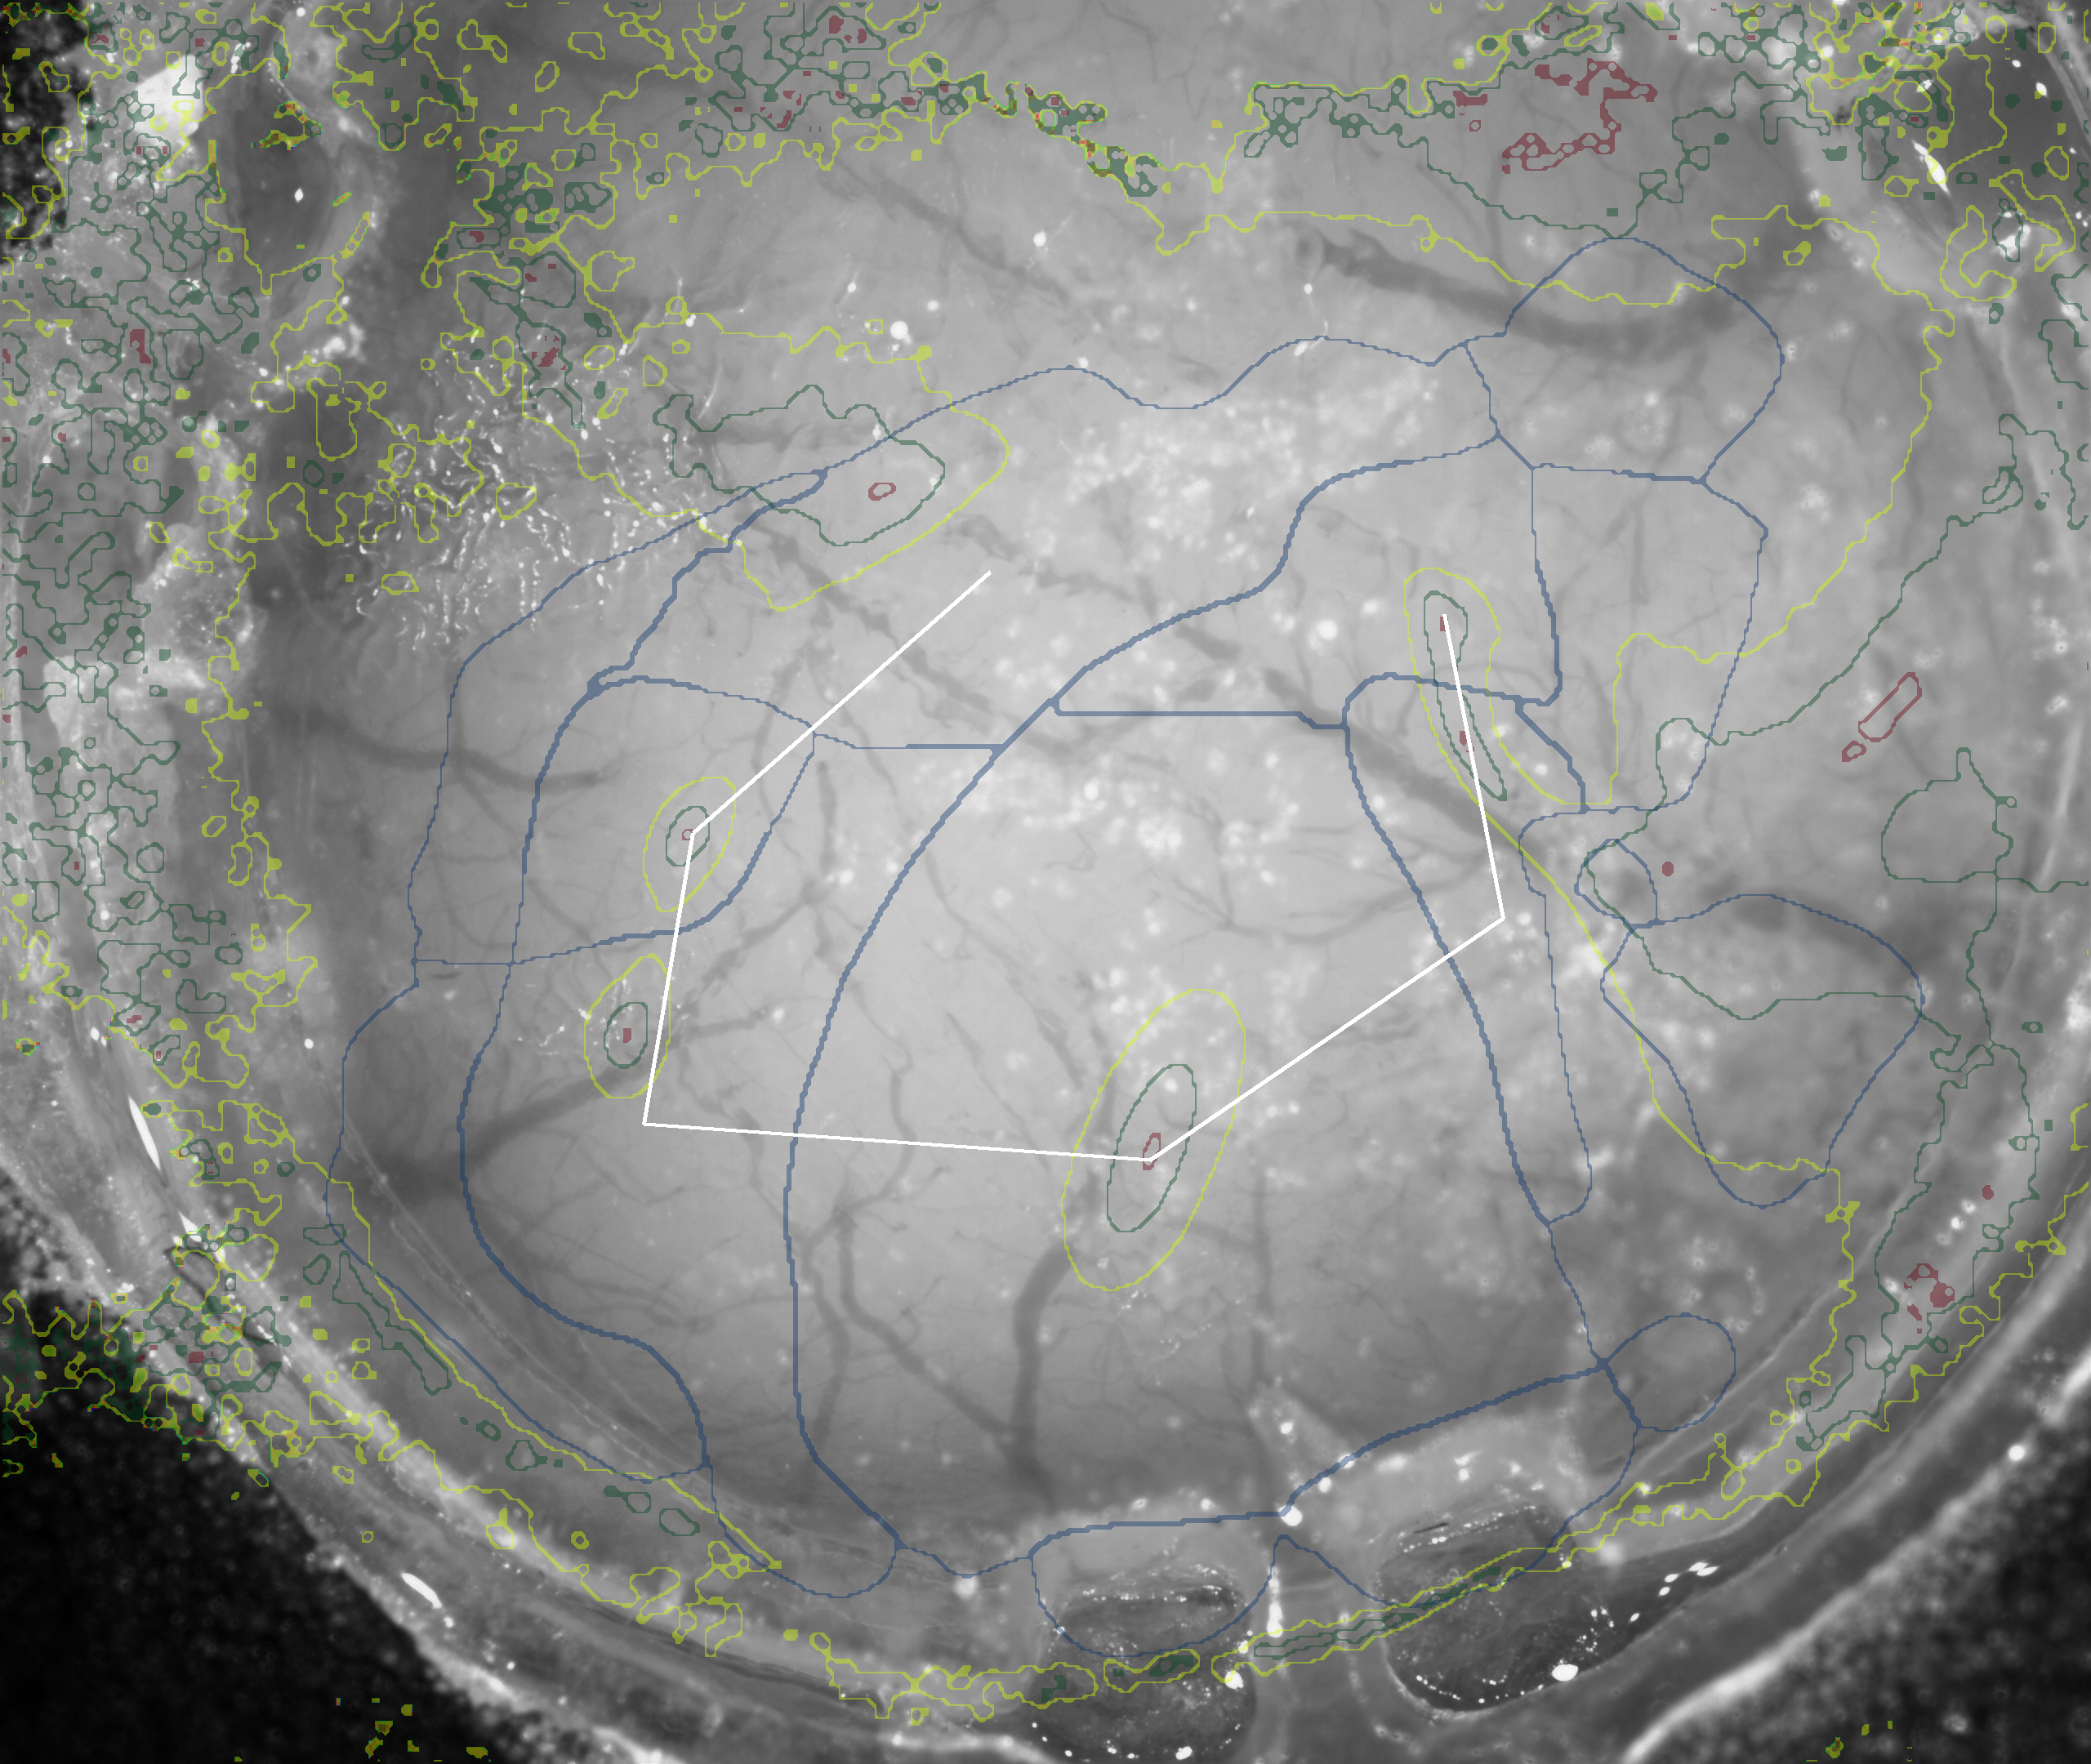

In [106]:
np_workflows.isi_widget(366122, colormap=False)

In [ ]:
np_workflows.isi_widget(366122, colormap=True)

In [ ]:
np_workflows.isi_widget(36612299999) # not in lims

In [ ]:
np_workflows.isi_widget(636766) # no ISI map

In [ ]:
np_workflows.print_countdown_timer(seconds=60)

In [ ]:
import tempfile
np_workflows.probe_targeting_widget(tempfile.tempdir)

In [ ]:
np_workflows.finishing_checks_widget()